In [73]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
from calcMAPE import calcMAPE
from numpy import newaxis
from sklearn.preprocessing import normalize

In [74]:
def getData(config):
    return pd.read_csv(config["dataLoc"]+config["fileName"])

In [75]:
def getConfig():
    config={}
    config["dataLoc"] = "/home/tbrownex/data/test/"
    config["fileName"] = "seasonal.csv"
    config["batchSize"] = 16
    config["segmentLength"] = 50
    config["epochs"] = 100
    config["opt"]  = "adam"
    config["testPct"] = 0.2
    return config

In [76]:
def prepData(df):
    '''
    Make sure the number of entries in the DF is a multiple of the segment Length
    '''
    extra = df.shape[0] % config["segmentLength"]
    if extra > 0:
        df = df[:-extra]
        print("{} rows removed".format(extra))
    return np.array(df["value"])

In [77]:
def scaleData(arr):
    arr = np.reshape(arr, newshape=[-1,1])
    arr = normalize(arr, norm="l2", axis=0)
    arr = np.reshape(arr, newshape=[-1,])
    return arr

In [78]:
def formatKeras(df):
    ''' Incoming data is 1D. Put it into 3D for keras where:
         2nd and 3rd dimensions are a plane with shape [segmentLength, 1]
         Stack the planes to make the 1st dimension.
         Each plane is the previous plane shifted by 1 byte.
         Skim off the last element in each plane (byte 50) for the label (y), 
         leaving 49 elements behind
         '''
    segments = []
    offset = 0
    while offset < (df.shape[0] - config["segmentLength"]):
        segment = df[offset:offset+config["segmentLength"]]
        segment = np.reshape(segment, newshape=[config["segmentLength"], 1])
        segments.append(segment)
        offset += 1
    arr = np.array(segments)
    x = arr[:, :-1]
    y = arr[:, -1, [0]]
    return x, y

In [79]:
def fitModel(model, config):
    m = model.fit(
        trainX,
        trainY,
        verbose=0,
        epochs= config["epochs"],
        batch_size = config["batchSize"])
    return m.history["loss"][0]

In [80]:
def addLayers(model, width):
    input_dim = 1
    return_seq = False
    use_bias = True
    bias_initializer="tom"
    L1size = 100
    L1act = "tanh"
    
    model.add(LSTM(units=L1size,
                   activation=L1act,
                   input_shape=(width, input_dim),
                   return_sequences=return_seq))
    model.add(Dense(1, activation="linear"))
    return model

In [81]:
def getPredictions(testX, testY):
    # The idea here is to get an initial segment to use for prediction. testX[0] is one segmentLength
    # After that, replace the testX with predicted values, one at a time
    testSeg = testX[0]
    testSeg = testSeg[newaxis,:,:]    # Needs to be 3D

    # Make the predictions
    predictions = []
    for _ in range(testY.shape[0]):
        pred = model.predict(testSeg, batch_size=1)[0][0]
        predictions.append(pred)
        # Shift the test segment one to the left and replace the rightmost value with the prediction
        testSeg = np.roll(testSeg, -1)
        testSeg[0,-1,0] = pred
    return predictions

In [82]:
config = getConfig()
df = getData(config)

arr = prepData(df)
arr = scaleData(arr)

print("Before formatting, data has shape: {}".format(arr.shape))
X,Y = formatKeras(arr)
print("After formatting, X has shape: {} and Y {}".format(X.shape, Y.shape))

testCount = int(X.shape[0]*(config["testPct"]))
trainX = X[:-testCount]
trainY = Y[:-testCount]
testX = X[-testCount:]
testY = Y[-testCount:]

Before formatting, data has shape: (1000,)
After formatting, X has shape: (950, 49, 1) and Y (950, 1)


In [83]:
width = trainX.shape[1]
model = Sequential()
model = addLayers(model, width)
model.compile(loss="mse", optimizer=config["opt"])
fitModel(model, config)
predictions = getPredictions(testX, testY)

In [84]:
# calculate the error
n = 20
mape = calcMAPE(testY[:n,0], np.array(predictions[:n]))
print("MAPE for the first {} predictions is {:.2%}".format(n, mape))

MAPE for the first 20 predictions is 3.70%


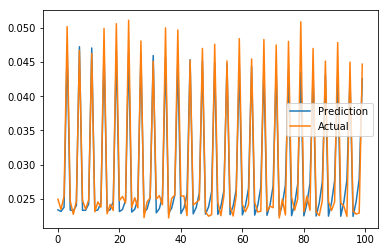

In [87]:
n=100
plt.plot(predictions[:n], label='Prediction')
plt.plot(testY[:n,0], label='Actual')
plt.legend()
plt.show()